In [1]:
%load_ext autoreload
%autoreload 2
from NeuralNetwork import *

In [44]:
.outputShape

(7, 7, 3)

In [45]:
np.prod(.outputShape)

16

In [46]:
from NeuralNetwork import *

model = NeuralNetowrk([Conv((5,5),3,0,(12,12,3),(1,1),sigmoid),Conv((5,5),4,0,(7,7,3),(1,1),sigmoid),Dense(16,10,sigmoid)])
model.allocateMemory(1)
x = Tensor(np.random.randn(*(1,10,10,1)))
y = Tensor(np.random.randn(1,10))
model.gradientDescent(x,y,0)
dw,db = model.testGrads(x,y)

In [29]:
model.gradientDescent(x,y,0)
model.layers[0].db

[[ 0.03551096 -0.50102866 -0.03100579  0.10778319]]

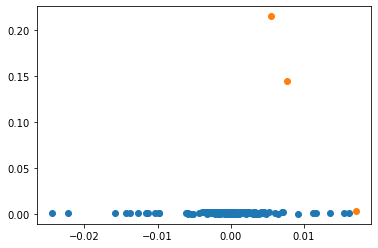

In [49]:
l = 0
plt.scatter(dw[l],model.layers[l].dw.get().flatten())
plt.scatter(db[l],model.layers[l].db.get().flatten())

In [4]:
%load_ext autoreload
from NeuralNetwork import *
programConv = cl.Program(context, open('kernelsConv.cpp').read()).build()
conv = Conv((5,5),4,0,(28,28,3),(2,2),sigmoid)

conv.allocateMemory(10)

ym1 = Tensor(np.random.randn(10,28,28,3))
Y = conv.forwardPropagate(ym1)
e = Tensor(Y.get())
conv.backwardPropagate(Y=Y,e=e, lrate=0)

print(conv.db.shape)
conv.db

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyError: 'sigma'

In [ ]:
conv = Conv((2,2),10,0,(10,10,1),(1,1),sigmoid)
conv.allocateMemory(1)
conv.w.set(np.ones(conv.w.shape))
conv.b.set(np.ones(conv.b.shape))
conv.forwardPropagate(Tensor(np.ones((1,10,10,1))))
conv.v

[[[[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]]

  [[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]]

  [[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]]

  [[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
   [5. 5. 5. 5